In [7]:
import torch
from SingleSessionSingleTrialDataset import SingleSessionSingleTrialDataset
import numpy as np
from pynwb import NWBHDF5IO

import os

dataset_path = "000070"
nwb_file_path = os.path.join(
    dataset_path, "sub-Jenkins", "sub-Jenkins_ses-20090916_behavior+ecephys.nwb")
io = NWBHDF5IO(nwb_file_path, 'r')
nwb_file = io.read()
hand_data = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].data[:]
hand_timestamps = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].timestamps[:]
trial_data = nwb_file.intervals['trials']

unit_spike_times = [nwb_file.units[unit_id]['spike_times'].iloc[0][:]
                    for unit_id in range(len(nwb_file.units))]
n_neurons = len(unit_spike_times)
n_context_bins = 50

n_trials = 400
datasets = [SingleSessionSingleTrialDataset(
    trial_data, hand_data, hand_timestamps, unit_spike_times, trial_id, bin_size=0.02, n_context_bins=n_context_bins) for trial_id in range(n_trials)]
dataset = torch.utils.data.ConcatDataset(datasets)
print(f"Dataset from {n_trials} trials has {len(dataset)} samples")

/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Dataset from 400 trials has 39713 samples


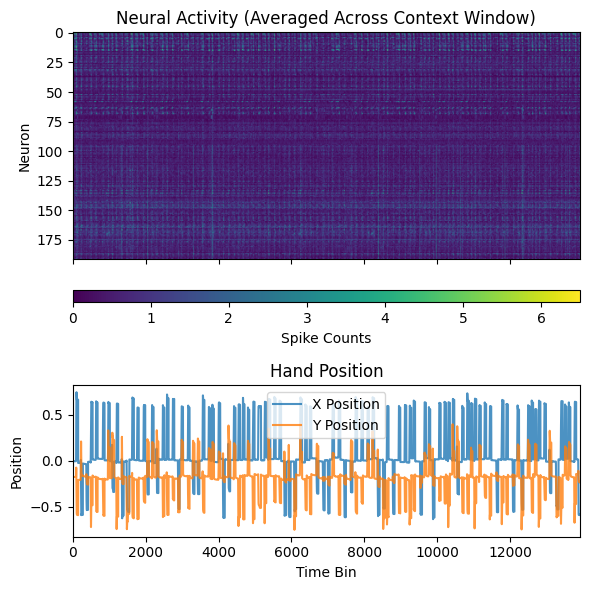

In [10]:
# Convert dataset to numpy arrays and visualize
import matplotlib.pyplot as plt

X = []
y = []
for i in range(len(dataset)):
    features, labels = dataset[i]
    X.append(features[:].numpy())
    y.append(labels.numpy())
X = np.array(X)
y = np.array(y)

# Create figure with subplots and shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), height_ratios=[2, 1], sharex=True)

# Plot heatmap of X
im = ax1.imshow(X.mean(axis=2).T, aspect='auto', cmap='viridis')
ax1.set_title('Neural Activity (Averaged Across Context Window)')
ax1.set_ylabel('Neuron')
# Add smaller colorbar at the top
cbar = plt.colorbar(im, ax=ax1, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Plot y coordinates
ax2.plot(y[:, 0], label='X Position', alpha=0.8)
ax2.plot(y[:, 1], label='Y Position', alpha=0.8)
ax2.set_title('Hand Position')
ax2.set_xlabel('Time Bin')
ax2.set_ylabel('Position')
ax2.legend()

plt.tight_layout()
plt.show()


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Convert dataset to numpy arrays
X = []
y = []
for i in range(len(dataset)):
    features, labels = dataset[i]
    X.append(features[:].flatten().numpy())
    y.append(labels.numpy())
X = np.array(X)
y = np.array(y)

# Split into train/test
split_idx = int(0.9 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Get predictions and scores
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Training R² score: {train_r2:.3f}")
print(f"Test R² score: {test_r2:.3f}")

# Also print separate R² scores for x and y coordinates
train_r2_x = r2_score(y_train[:,0], train_pred[:,0])
train_r2_y = r2_score(y_train[:,1], train_pred[:,1])
test_r2_x = r2_score(y_test[:,0], test_pred[:,0])
test_r2_y = r2_score(y_test[:,1], test_pred[:,1])

print(f"\nTraining R² score (x-coordinate): {train_r2_x:.3f}")
print(f"Training R² score (y-coordinate): {train_r2_y:.3f}")
print(f"Test R² score (x-coordinate): {test_r2_x:.3f}") 
print(f"Test R² score (y-coordinate): {test_r2_y:.3f}")


Training R² score: 0.829
Test R² score: 0.644

Training R² score (x-coordinate): 0.879
Training R² score (y-coordinate): 0.779
Test R² score (x-coordinate): 0.771
Test R² score (y-coordinate): 0.517


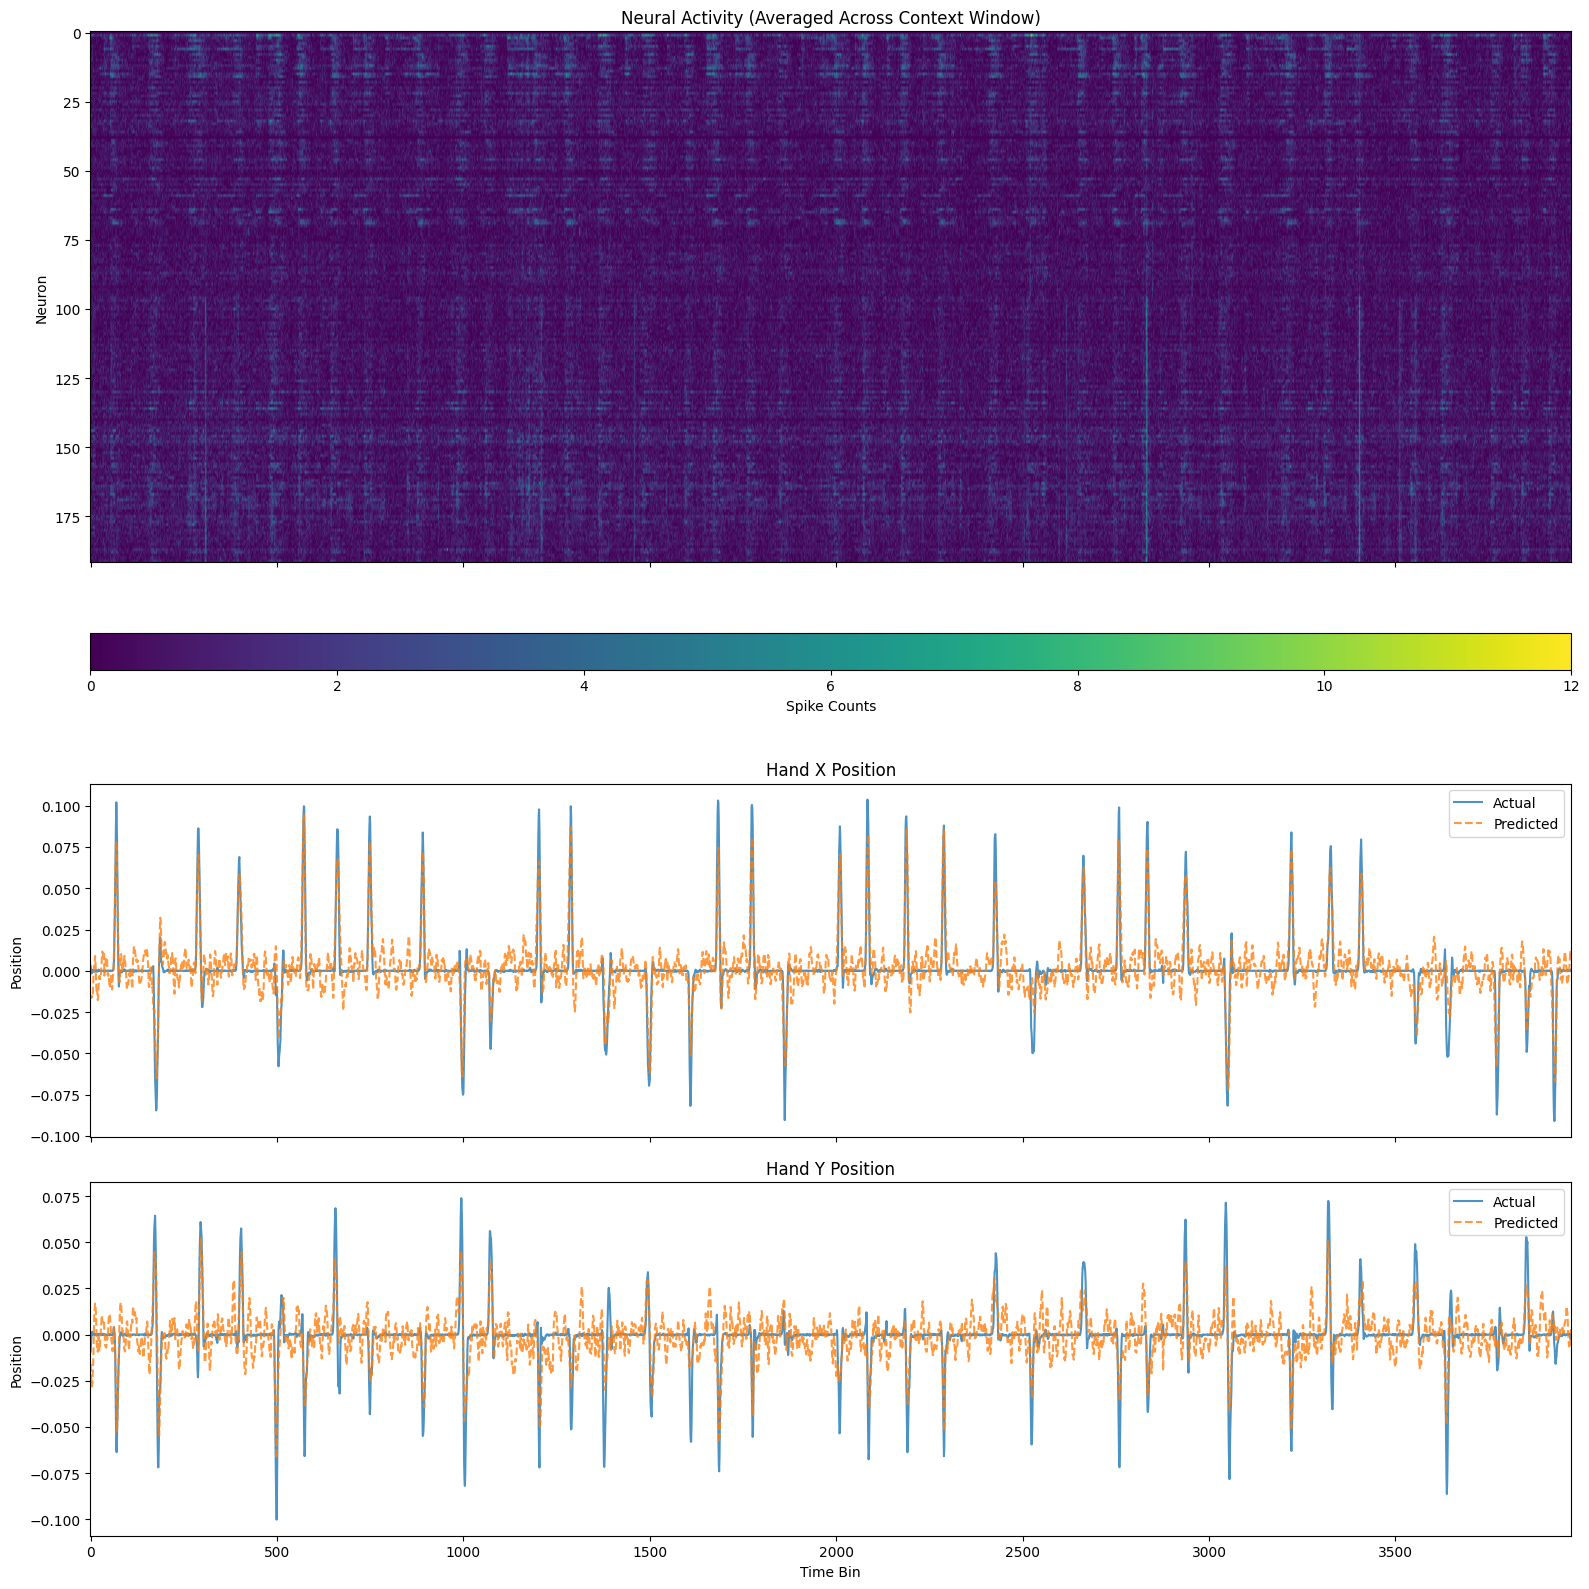

In [10]:
# Convert dataset to numpy arrays and visualize
import matplotlib.pyplot as plt

# Create figure with subplots and shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 16), height_ratios=[2, 1, 1], sharex=True)

# Plot heatmap of X
im = ax1.imshow(X_test.reshape(-1, n_neurons, n_context_bins)[:, :, -1].T, aspect='auto', cmap='viridis')
ax1.set_title('Neural Activity (Averaged Across Context Window)')
ax1.set_ylabel('Neuron')
# Add smaller colorbar at the top
cbar = plt.colorbar(im, ax=ax1, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Plot x coordinate
ax2.plot(y_test[:, 0], label='Actual', alpha=0.8)
ax2.plot(test_pred[:, 0], label='Predicted', alpha=0.8, linestyle='--')
ax2.set_title('Hand X Position')
ax2.set_ylabel('Position')
ax2.legend()

# Plot y coordinate
ax3.plot(y_test[:, 1], label='Actual', alpha=0.8)
ax3.plot(test_pred[:, 1], label='Predicted', alpha=0.8, linestyle='--')
ax3.set_title('Hand Y Position')
ax3.set_xlabel('Time Bin')
ax3.set_ylabel('Position')
ax3.legend()

plt.tight_layout()
plt.show()
